In [1]:
import torch
from torchvision import models, transforms
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import requests
from io import BytesIO

# For superpixel segmentation
from skimage.segmentation import slic
from skimage.segmentation import mark_boundaries

In [2]:
%matplotlib inline

# Helper Functions

In [3]:
with open("imagenet_classes.txt") as f:
    classes = [line.strip() for line in f.readlines()]

In [4]:
# Choose device: use GPU if available, else CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
# 2) Helper: Load an Image from URL
############################################
def load_image_from_url(url):
    """
    Load an image from a URL and return it as a PIL Image.
    """
    response = requests.get(url)
    pil_img = Image.open(BytesIO(response.content)).convert("RGB")
    return pil_img

In [6]:
# 1. Segment the image into superpixels using SLIC.

def segment_image(image, n_segments=200):
    """
    Segment the image into superpixels.
    :param image: Input image as a NumPy array (H, W, 3) in RGB.
    :param n_segments: Number of desired superpixels.
    :return: A segmentation label array.
    """
    segments = slic(image, n_segments=n_segments, compactness=5, sigma=1, start_label=0)
    return segments

In [7]:
# 2. Perturb the image given a binary mask.
def perturb_image(image, segments, binary_mask, hide_color=None):
    """
    Replace the pixels in segments turned "off" (binary_mask==0) with hide_color.
    :param image: Original image as a NumPy array.
    :param segments: Segmentation labels for each pixel.
    :param binary_mask: 1D array (length = number of segments) with 1=keep and 0=hide.
    :param hide_color: Color to use for hidden regions; if None, uses the global mean.
    :return: Perturbed image as a NumPy array.
    :param hide_color: The hide_color parameter is used to "hide" a superpixel by replacing all its pixels with a specific, uniform color. This makes the superpixel effectively disappear from the image, providing a consistent baseline when the classifier processes the perturbed image.
    """
    if hide_color is None:
        # Compute global mean color (per channel)
        hide_color = np.mean(image, axis=(0, 1)).astype(image.dtype)
    perturbed = image.copy()
    for seg_val in np.unique(segments):
        if binary_mask[int(seg_val)] == 0:
            perturbed[segments == seg_val] = hide_color
    return perturbed

In [8]:
# 3. Generate many perturbed samples (binary vectors) for superpixels.

def generate_perturbed_samples(num_segments, num_samples=1000, random_state=None):
    """
    Generate a set of binary vectors representing which superpixels are kept.
    The original image corresponds to a vector of all ones.
    :param num_segments: Number of superpixels.
    :param num_samples: Total number of samples (including the original).
    :param random_state: Optional integer for reproducibility.
    :return: Array of shape (num_samples, num_segments).
    """
    rng = np.random.RandomState(random_state) # For Reproducibility

    # sample array to hold the binary vectors
    # Each row corresponds to a sample, and each column corresponds to a superpixel.
    samples = []

    # Ensure the original instance (all ones) is the first sample.
    # The original image contains all superpixels, so we have all 1.
    samples.append(np.ones(num_segments, dtype=int))
    
    # So except the first original image, we iterate n-1 times to generate the rest of the samples.
    # We sample from binomial for each superpixel (0 or 1 bernoulli trial).

    # So this process is generating random binary vectors.
    for _ in range(num_samples - 1):
        sample = rng.binomial(1, 0.5, size=num_segments)
        samples.append(sample)

    return np.array(samples)

In [9]:
# 4. Compute an exponential kernel weight for each perturbed sample.

# We need an exponential kernel, notation of phi in the paper.
# weight of a perturbed image (Based on the distance metric between original image and perturbed image, 
# so when the perturbed image is similar to the original image, the weight is high, and when it is far from the original image, the weight is low.)

def compute_kernel_distance(binary_samples, sigma=0.25):
    """
    Compute weights based on the fraction of segments turned off.
    :param binary_samples: Array of binary vectors (n_samples x num_segments).
    :param sigma: Kernel width.
    :return: Weights as a 1D numpy array.
    """
    num_segments = binary_samples.shape[1]
    # Distance is the fraction of segments turned off.
    # Compute the distance as the fraction of segments turned off.
    # A natural choice for the distance D(x, z) is to measure how many superpixels have been “turned off.”
    # Mathematically, if there are d superpixels and a perturbed sample z has ∑z_i ones,
    # then the number of superpixels turned off is d - ∑z_i.
    distances = (num_segments - np.sum(binary_samples, axis=1)) / num_segments
    weights = np.exp(- (distances ** 2) / (sigma ** 2))
    return weights

In [10]:
# 5. Batch prediction function.

# designed to take a collection of images, process them in a single batch, and return the model’s predicted probabilities for each image



def batch_predict(images, model, transform):
    """
    Given a list/array of images (numpy arrays), predict probabilities using the model.
    :param images: NumPy array of images (n_samples, H, W, 3), assumed to be in uint8.
    :param model: Pretrained PyTorch model.
    :param transform: Transformation function to preprocess images.
    :return: NumPy array of predicted probabilities for each class.
    """

    # Set the model to eval mode to disable dropout and batch normalization.
    model.eval()

    # Convert image (Currently in numpy array) to PIL Image
    # Tranform re-make it into tensor, and append to a tensor list.
    tensors = []
    for img in images:
        pil_img = Image.fromarray(img.astype('uint8'))
        tensor = transform(pil_img)
        tensors.append(tensor)

    # The list of tensors is combined into a single batch using torch.stack(). 
    # This function stacks each tensor along a new dimension, resulting in a 4D tensor with shape (n_samples, C, H, W)
    batch = torch.stack(tensors).to(device)

    # Disable gradient computation (NO NEED IN INFENRCE).
    # Process entire batch in one forward pass.
    with torch.no_grad():
        logits = model(batch)


    probs = torch.nn.functional.softmax(logits, dim=1)
    # Why computation along dim=1 ?
    # When you have a batch of images, for example with shape (batch_size, num_classes), applying softmax along dimension 1 (dim=0 : batch_size, here we have 1 batch, dim=1 num of classes)
    # So we have 1 x num_classes tensor
    # The softmax function is applied to each row of the tensor, ensuring that the values in each row sum to 1.
    
    return probs.cpu().numpy()

In [11]:
# 6. Weighted linear regression (with intercept).
def weighted_linear_regression(X, y, sample_weights):
    """
    Solve for coefficients in weighted least squares:
    w = argmin || sqrt(W) (y - X_design * coef) ||^2.
    X_design includes an intercept column.
    :param X: Design matrix of shape (n_samples, n_features).
    :param y: Target vector of shape (n_samples,).
    :param sample_weights: Weights for each sample.
    :return: Coefficients vector (first element is intercept).
    """

    # X : Original binary vector matrix (Each row: 1 perturbed image, Each column: 1 superpixel)
    # X_design : Just add an intercept column to X. first column (all ones) allows the regression model to have an intercept
    # W : Diagonal weight matrix from weights using exponential kernel. (Give more importance to perturbed samples that are similar to the original image.)
    # beta: Regression coefficients

    n, d = X.shape
    
    # Step 3: Incorporate the intercept and prepare the design matrix.
    # ---------------------------------------------------------------
    # Our original binary feature matrix X has shape (n, d), where:
    #   n = number of perturbed samples,
    #   d = number of superpixels.
    #
    # We add a column of ones to X to allow for an intercept in our model.
    # The new matrix X_design has shape (n, d+1) and is defined as:
    #
    #   X_design = [1   X]
    #              [1   X]
    #              ... 
    #
    # Mathematically, for each sample i:
    #   (X_design)_i = [1, x_i1, x_i2, ..., x_id]
    #
    # This allows our local linear model to have the form:
    #   f(z_i) ≈ β₀ + β₁*x_i1 + β₂*x_i2 + ... + β_d*x_id
    X_design = np.concatenate([np.ones((n, 1)), X], axis=1)  # X_design: (n, d+1)

    # We then construct the weight matrix W as a diagonal matrix.
    # Each diagonal element W_ii is the weight for sample i,
    # computed earlier using an exponential kernel:
    #
    #   w_i = exp( - (D(x, z_i)^2) / σ^2 )
    #
    # where D(x, z_i) is the normalized distance between the original image x and
    # the perturbed sample z_i. This matrix W ensures that samples closer to x
    # (i.e., more similar) have higher influence.
    W = np.diag(sample_weights)

    # Step 4: Solve the weighted least squares problem to find β.
    # ---------------------------------------------------------------
    # Our objective is to minimize the weighted sum of squared errors:
    #
    #   min_β Σᵢ w_i (y_i - (X_design)_i · β)²
    #
    # In matrix notation, we write the objective as:
    #
    #   min_β || sqrt(W) (y - X_design · β) ||²
    #
    # The normal equation for the weighted least squares solution is:
    #
    #   (X_designᵀ W X_design) β = X_designᵀ W y
    #
    # We compute the left-hand side (A) and the right-hand side (b) of this equation:
    A = X_design.T @ W @ X_design   # A = X_designᵀ W X_design

    # Since W is a diagonal matrix, multiplying by W is equivalent to element-wise multiplication:
    b = X_design.T @ (sample_weights * y)  # b = X_designᵀ W y

    # Finally, we solve for β (the coefficients, where β₀ is the intercept)
    # using linear algebra:
    coef = np.linalg.solve(A, b)
    return coef

In [12]:
# 7. Get an explanation mask based on top features.
def get_explanation_mask(segments, feature_weights, num_features=5):
    """
    Return a boolean mask indicating pixels belonging to the top segments.
    :param segments: Array of segmentation labels.
    :param feature_weights: Array of weights (length equals number of segments).
    :param num_features: How many segments to highlight.
    :return: Boolean mask with True for pixels in selected segments.
    """
    # Get indices of top features (segments) with highest positive contribution.
    # The get_explanation_mask function extracts the top contributors and creates a mask for visualization, 
    # aligning with the concept of highlighting key regions as seen in the paper's figures.

    # Sort the Feature Weights: Identify the superpixels with the highest positive contributions.
    top_indices = np.argsort(feature_weights)[-num_features:]

    # Initialize "mask" array
    mask = np.zeros_like(segments, dtype=bool)

    # Append the top indices to the mask.
    for i in top_indices:
        mask[segments == i] = True
    return mask

# Main Explanation Funciton

In [13]:
# 11) Main "Explain Instance" Function

def explain_instance(image, model, transform, num_samples=1000, sigma=0.25,
                     n_segments=50, random_state=42, num_features=5):
    """
    Produce a local explanation for the top predicted class using a LIME-like approach.
    
    Steps:
      1) Segment the image into superpixels.
      2) Generate binary perturbations of the superpixels.
      3) Create perturbed images.
      4) Identify the target class from the original image.
      5) Batch predict probabilities for perturbed images.
      6) Compute kernel weights for each perturbed sample.
      7) Fit a weighted linear regression to approximate the model locally.
      8) Return an explanation mask highlighting the top superpixels.
    """
    # Segment the image
    segments = segment_image(image, n_segments=n_segments)
    num_segments_actual = len(np.unique(segments))
    
    # Generate perturbed binary masks
    binary_samples = generate_perturbed_samples(num_segments_actual, num_samples, random_state)
    
    # Create perturbed images based on the binary masks
    perturbed_images = []
    for binary_mask in binary_samples:
        perturbed = perturb_image(image, segments, binary_mask)
        perturbed_images.append(perturbed)
    perturbed_images = np.array(perturbed_images)
    
    # Identify the target class by predicting on the original image
    orig_tensor = transform(Image.fromarray(image)).unsqueeze(0).to(device)
    with torch.no_grad():
        orig_logits = model(orig_tensor)
        orig_probs = torch.nn.functional.softmax(orig_logits, dim=1)
    target_class = int(torch.argmax(orig_probs[0]).item())
    
    # Batch predict probabilities on all perturbed images
    preds = batch_predict(perturbed_images, model, transform)
    target_preds = preds[:, target_class]  # Get probability for the target class
    
    # Compute kernel weights for each sample
    weights = compute_kernel_distance(binary_samples, sigma)
    
    # Fit a weighted linear regression on the binary features
    coef = weighted_linear_regression(binary_samples, target_preds, weights)
    intercept = coef[0]
    feature_weights = coef[1:]  # Coefficients corresponding to each superpixel
    
    # Build an explanation mask for visualization (highlight top superpixels)
    explanation_mask = get_explanation_mask(segments, feature_weights, num_features)
    
    # Return all useful information as a dictionary.
    return {
        "segments": segments,
        "binary_samples": binary_samples,
        "target_preds": target_preds,
        "weights": weights,
        "intercept": intercept,
        "feature_weights": feature_weights,
        "target_class": target_class,
        "explanation_mask": explanation_mask,
    }

In [14]:
# 12) Putting It All Together


# 1. Load the pretrained ResNet50 model using the new torchvision API.
model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
model.to(device)
model.eval()

# 2. Define the transformation pipeline for preprocessing images for ResNet50.
transform = transforms.Compose([
    transforms.Resize(256),       # Resize shorter side to 256 pixels
    transforms.CenterCrop(224),   # Center crop to 224x224
    transforms.ToTensor(),        # Convert PIL Image to Torch tensor
    transforms.Normalize(         # Normalize using ImageNet mean and std
        mean=[0.485, 0.456, 0.406],
        std =[0.229, 0.224, 0.225]
    )
])

# 3. Load a snake image from an external URL.
snake_url = "https://github.com/utkuozbulak/pytorch-cnn-visualizations/blob/master/input_images/snake.png?raw=true"
snake_pil = load_image_from_url(snake_url)
snake_np = np.array(snake_pil)  # Convert the PIL image to a NumPy array (H, W, 3)

# 4. Generate a LIME-like explanation for the snake image.
explanation = explain_instance(
    image=snake_np,
    model=model,
    transform=transform,
    num_samples=1000,    # Number of perturbed samples to generate
    sigma=0.25,          # Kernel width for weighting
    n_segments=50,       # Number of superpixels via SLIC
    random_state=42,     # For reproducibility
    num_features=5       # Number of top superpixels to highlight in the explanation
)

In [15]:
# 5. Print the predicted class for the snake image.
predicted_class = explanation["target_class"]
print("Predicted Class Index:", predicted_class)
print("Predicted Class Label:", classes[predicted_class])


Predicted Class Index: 56
Predicted Class Label: king snake


In [16]:
# 6. Debug: Print the top superpixel indices and their corresponding weights.
feature_weights = explanation["feature_weights"]
top_superpixels = np.argsort(feature_weights)[-5:]
print("\nTop 5 superpixel indices:", top_superpixels)
print("Corresponding weights:", feature_weights[top_superpixels])


Top 5 superpixel indices: [ 1  9  7 13  6]
Corresponding weights: [0.00958412 0.01171455 0.01204296 0.01555235 0.10844548]


(-0.5, 223.5, 223.5, -0.5)

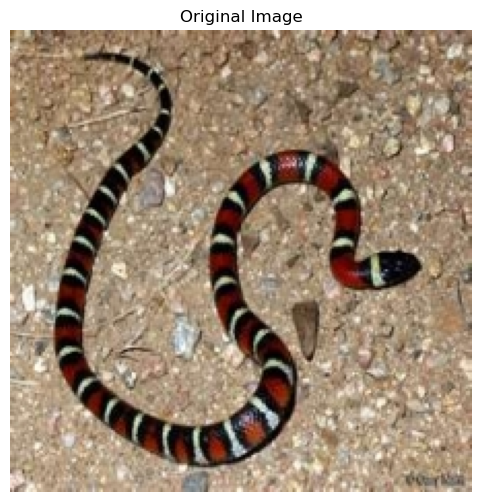

In [17]:
# 7. Visualize the explanation.
fig, ax = plt.subplots(figsize=(8, 6))

# Display the original snake image.
ax.imshow(snake_np)
ax.set_title("Original Image")
ax.axis("off")


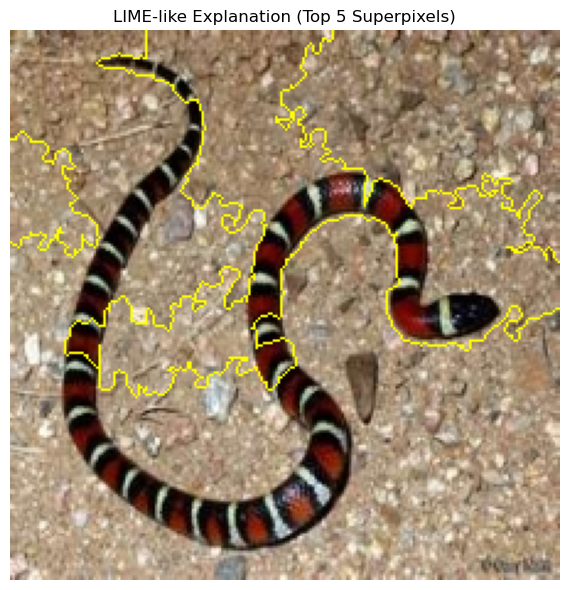

In [18]:
%matplotlib inline

# Create a figure with two subplots
fig, ax = plt.subplots(figsize=(8, 6))
# Overlay the explanation mask (highlight boundaries of top superpixels).
explanation_mask = explanation["explanation_mask"]
ax.imshow(mark_boundaries(snake_np, explanation_mask.astype(int)))
ax.set_title("LIME-like Explanation (Top 5 Superpixels)")
ax.axis("off")

plt.tight_layout()
plt.show()

# Debug

In [19]:
print("Segments shape:", explanation["segments"].shape)
print("Unique segment labels:", np.unique(explanation["segments"]))


Segments shape: (224, 224)
Unique segment labels: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21]


In [20]:
print("Explanation mask shape:", explanation["explanation_mask"].shape)
print("Mask unique values:", np.unique(explanation["explanation_mask"]))


Explanation mask shape: (224, 224)
Mask unique values: [False  True]


In [21]:
feature_weights = explanation["feature_weights"]
top_superpixels = np.argsort(feature_weights)[-5:]
print("Top superpixels:", top_superpixels)
print("Weights of top superpixels:", feature_weights[top_superpixels])


Top superpixels: [ 1  9  7 13  6]
Weights of top superpixels: [0.00958412 0.01171455 0.01204296 0.01555235 0.10844548]


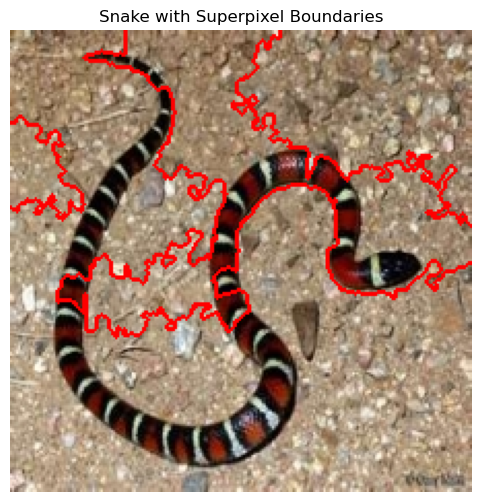

In [22]:
%matplotlib inline
import matplotlib.pyplot as plt
from skimage.segmentation import mark_boundaries

# Create a figure with two subplots
fig, ax = plt.subplots(figsize=(8, 6))

# Increase outline thickness or change color:
ax.imshow(mark_boundaries(
    snake_np, 
    explanation["explanation_mask"].astype(int),
    color=(1, 0, 0),       # Red boundaries instead of green
    mode='thick'           # Thicker boundaries
))

ax.set_title("Snake with Superpixel Boundaries")
ax.axis("off")  # Hide the axes
plt.show()

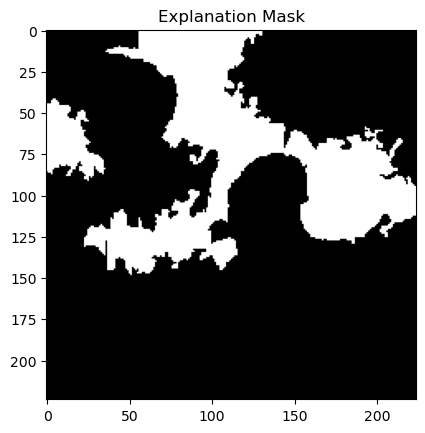

In [23]:
plt.imshow(explanation["explanation_mask"], cmap='gray')
plt.title("Explanation Mask")
plt.show()
